# [1] Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## [7.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
warnings.filterwarnings("ignore")

%matplotlib inline 
# sets the backend of matplotlib to the 'inline' backend:
#With this backend, the output of plotting commands is displayed inline within frontends like the Jupyter notebook,
#directly below the code cell that produced it. The resulting plots will then also be stored in the notebook document.

#Functions to save objects for later use and retireve it
import pickle
def savetofile(obj,filename):
    pickle.dump(obj,open(filename+".p","wb"))
def openfromfile(filename):
    temp = pickle.load(open(filename+".p","rb"))
    return temp

C:\Users\Sai charan\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


#  Exploratory Data Analysis

## [7.1.2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [2]:
#Using sqlite3 to retrieve data from sqlite file

con = sqlite3.connect("final.sqlite")#Loading Cleaned/ Preprocesed text that we did in Text Preprocessing

#Using pandas functions to query from sql table
final = pd.read_sql_query("""
SELECT * FROM Reviews order by Time
""",con)

#Reviews is the name of the table given
#Taking only the data where score != 3 as score 3 will be neutral and it won't help us much
final.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
2,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
3,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
4,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


In [3]:
final['Score'] = final['Score'].replace('positive',1)
final['Score'] = final['Score'].replace('negative',0)

In [4]:
final.duplicated(subset={"UserId","ProfileName","Time","Text"}).value_counts()

False    364171
dtype: int64

In [5]:
final =  final.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep="first")

In [6]:
final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]
print("Size of data",final['Id'].size," rows ")

Size of data 364171  rows 


In [7]:
import re #Regex (Regualar Expr Operations)
#string = r"sdfsdfd" :- r is for raw string as Regex often uses \ backslashes(\w), so they are often raw strings(r’\d’)

########Function to remove html tags from data
def striphtml(data):
    p = re.compile('<.*?>')#Find this kind of pattern
#     print(p.findall(data))#List of strings which follow the regex pattern
    return p.sub('',data) #Substitute nothing at the place of strings which matched the patterns

striphtml('<a href="foo.com" class="bar">I Want This <b>text!</b></a><>')

'I Want This text!'

In [8]:
def strippunc(data):
    p = re.compile(r'[?|!|\'|"|#|.|,|)|(|\|/|~|%|*]')
    return p.sub('',data)
strippunc("fsd*?~,,,( sdfsdfdsvv)#")

'fsd sdfsdfdsvv'

In [9]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = stopwords.words('english') #All the stopwords in English language
#excluding some useful words from stop words list as we doing sentiment analysis
excluding = ['against','not','don', "don't",'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't",
             'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 
             'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't",'shouldn', "shouldn't", 'wasn',
             "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
stop = [words for words in stop if words not in excluding]
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's',

In [10]:
from nltk.stem import SnowballStemmer
snow = SnowballStemmer('english') #initialising the snowball stemmer
print("Stem/Root words of the some of the words using SnowBall Stemmer:")
print(snow.stem('tasty'))
print(snow.stem('tasteful'))
print(snow.stem('tastiest'))
print(snow.stem('delicious'))
print(snow.stem('amazing'))
print(snow.stem('amaze'))
print(snow.stem('initialize'))
print(snow.stem('fabulous'))
print(snow.stem('Honda City'))
print(snow.stem('unpleasant'

))

Stem/Root words of the some of the words using SnowBall Stemmer:
tasti
tast
tastiest
delici
amaz
amaz
initi
fabul
honda c
unpleas


In [11]:
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'][2:3].values: #Running only for 2nd review
    filtered_sentence=[]
    print(sent) #Each review
    sent=striphtml(sent)# remove HTMl tags
    sent=strippunc(sent)# remove Punctuation Symbols
    print(sent.split())
    for w in sent.split():
        print("================================>",w)
        if((w.isalpha()) and (len(w)>2)):#If it is a numerical value or character of lenght less than 2    
            if(w.lower() not in stop):# If it is a stopword
                s=(snow.stem(w.lower())).encode('utf8') #Stemming the word using SnowBall Stemmer
                print("Selected: Stem Word->",s)
                filtered_sentence.append(s)
            else:
                print("Eliminated as it is a stopword")
                continue
        else:
            print("Eliminated as it is a numerical value or character of lenght less than 2")
            continue 
#     print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    final_string.append(str1)
    print("***********************************************************************")
    print("Finally selected words from the review:\n",final_string)

Beetlejuice is a well written movie ..... everything about it is excellent! From the acting to the special effects you will be delighted you chose to view this movie.
['Beetlejuice', 'is', 'a', 'well', 'written', 'movie', 'everything', 'about', 'it', 'is', 'excellent', 'From', 'the', 'acting', 'to', 'the', 'special', 'effects', 'you', 'will', 'be', 'delighted', 'you', 'chose', 'to', 'view', 'this', 'movie']
================================> Beetlejuice
Selected: Stem Word-> b'beetlejuic'
================================> is
Eliminated as it is a numerical value or character of lenght less than 2
================================> a
Eliminated as it is a numerical value or character of lenght less than 2
================================> well
Selected: Stem Word-> b'well'
================================> written
Selected: Stem Word-> b'written'
================================> movie
Selected: Stem Word-> b'movi'
================================> everything
Selected: Stem Word-> b'every

In [12]:
%%time
# Code takes a while to run as it needs to run on around 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
#     print(sent) #Each review
    sent=striphtml(sent)# remove HTMl tags
    sent=strippunc(sent)# remove Punctuation Symbols
#     print(sent.split())
    for w in sent.split():
#         print("================================>",w)
        if((w.isalpha()) and (len(w)>2)):#If it is a numerical value or character of lenght less than 2    
            if(w.lower() not in stop):# If it is a stopword
                s=(snow.stem(w.lower())).encode('utf8') #Stemming the word using SnowBall Stemmer
                                        #encoding as byte-string/utf-8
#                 print("Selected: Stem Word->",s)
                filtered_sentence.append(s)
                if (final['Score'].values)[i] == 'Positive': 
                    all_positive_words.append(s) #list of all words used to describe positive reviews
                if(final['Score'].values)[i] == 'Negative':
                    all_negative_words.append(s) #list of all words used to describe negative reviews reviews
            else:
#                 print("Eliminated as it is a stopword")
                continue
        else:
#             print("Eliminated as it is a numerical value or character of lenght less than 2")
            continue 
#     print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
            #encoding as byte-string/utf-8
    
    final_string.append(str1)
#     print("***********************************************************************")
#     print("Finally selected words from the review:\n",final_string)
    i+=1

Wall time: 18min 12s


In [13]:
%%time
# Code takes a while to run as it needs to run on around 500k sentences.
i=0
str1=' '
final_string_nostem=[]
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=striphtml(sent)# remove HTMl tags
    sent=strippunc(sent)# remove Punctuation Symbols
    for w in sent.split():
        if((w.isalpha()) and (len(w)>2)):#If it is a numerical value or character of lenght less than 2    
            if(w.lower() not in stop):# If it is a stopword
                s=w.lower().encode('utf8') #encoding as byte-string/utf-8
            else:
                continue
        else:
            continue 
    str1 = b" ".join(filtered_sentence)     
    final_string_nostem.append(str1)
    i+=1

Wall time: 2min 6s


In [14]:
#Adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final_string
final['CleanedText_NoStem']=final_string_nostem
final.head(3)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedText_NoStem
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...,b''
1,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...,b''
2,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel a...,b''


In [15]:
final.sort_values('Time',inplace=True) 
final.head(10)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedText_NoStem
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...,b''
1,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...,b''
2,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel a...,b''
3,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",b'twist rumplestiskin captur film star michael...,b''
4,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel funni movi keaton hilari wa...,b''
5,346116,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,1,947376000,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,b'one movi movi collect fill comedi action wha...,b''
6,346041,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,0,948240000,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",b'alway enjoy movi funni entertain didnt hesit...,b''
7,70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,1,948672000,A sure death for flies,I bought a few of these after my apartment was...,b'bought apart infest fruit fli hour trap mani...,b''
8,346141,374450,B00004CI84,ACJR7EQF9S6FP,Jeremy Robertson,2,3,1,951523200,Bettlejuice...Bettlejuice...BETTLEJUICE!,What happens when you say his name three times...,b'happen say name three time michael keaten st...,b''
10,417883,451903,B00004CXX9,A2DEE7F9XKP3ZR,jerome,0,1,1,959990400,Research,I'm getting crazy.<p>Is it really impossible t...,b'get crazyi realli imposs today not find fren...,b''


In [16]:
final=final[:100000]

In [17]:
savetofile(final,"sample_lr")

In [18]:
final = openfromfile("sample_lr")

# [7.2.2] Bag of Words (BoW)

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(final['CleanedText'].values,final['Score'].values,test_size=0.3,shuffle=False)

#Text -> Uni gram Vectors
uni_gram = CountVectorizer() 
X_train = uni_gram.fit_transform(X_train)
#Normalize Data
X_train = preprocessing.normalize(X_train)

X_test = uni_gram.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X_train = sc.fit_transform(X_train)
X_test= sc.transform(X_test)
print("Test Data Size: ",X_test.shape)
print("Train Data Size: ",X_train.shape)

Test Data Size:  (30000, 64925)
Train Data Size:  (70000, 64925)


In [20]:
#To show how Time Series Split splits the data
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)
for train, cv in tscv.split(X_train):
#     print("%s %s" % (train, cv))
    print(X_train[train].shape, X_train[cv].shape)

(6370, 64925) (6363, 64925)
(12733, 64925) (6363, 64925)
(19096, 64925) (6363, 64925)
(25459, 64925) (6363, 64925)
(31822, 64925) (6363, 64925)
(38185, 64925) (6363, 64925)
(44548, 64925) (6363, 64925)
(50911, 64925) (6363, 64925)
(57274, 64925) (6363, 64925)
(63637, 64925) (6363, 64925)


# GridSearchCV

In [21]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
#params we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='f1_micro')
gsv.fit(X_train,y_train)
savetofile(gsv,"Log Reg/gsv_bi")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Wall time: 0 ns
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 75.3min finished


Best HyperParameter:  {'C': 0.05, 'penalty': 'l1'}
Best Accuracy: 91.79%


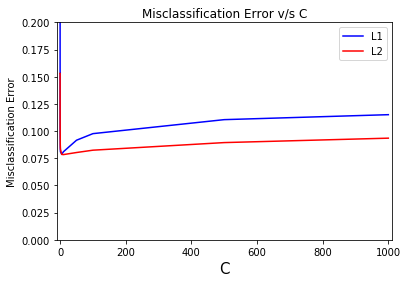

In [22]:
def plot_error_vs_c(gsv):
    x1=[]
    y1=[]
    x2=[]
    y2=[]
    for a in gsv.grid_scores_:
        if (a[0]['penalty']) == 'l1':
            y1.append(1-a[1])
            x1.append(a[0]['C'])
        else:
            y2.append(1-a[1])
            x2.append(a[0]['C'])
    plt.xlim(-10,1010)
    plt.ylim(0,0.2)
    plt.xlabel("C",fontsize=15)
    plt.ylabel("Misclassification Error")
    plt.title('Misclassification Error v/s C')
    plt.plot(x1,y1,'b',label="L1")
    plt.plot(x2,y2,'r',label="L2")
    plt.legend()
    plt.show()
gsv = openfromfile("Log Reg/gsv_uni")
plot_error_vs_c(gsv)

In [23]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    
    B =(C/C.sum(axis=0))
    
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    #representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    #representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Accuracy on train set: 98.463%
Precision on train set: 0.986
Recall on train set: 0.997
F1-Score on train set: 0.985
Non Zero weights: 13254
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



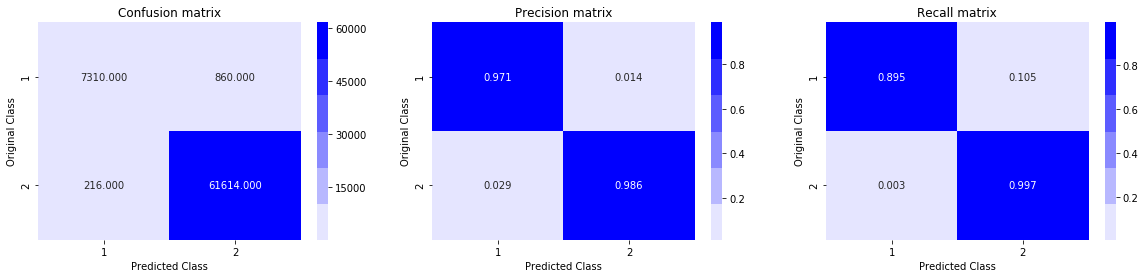

Accuracy on test set: 91.573%
Precision on test set: 0.938
Recall on test set: 0.967
F1-Score on test set: 0.916
Non Zero weights: 13254
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]

Confusion matrix for the model is:


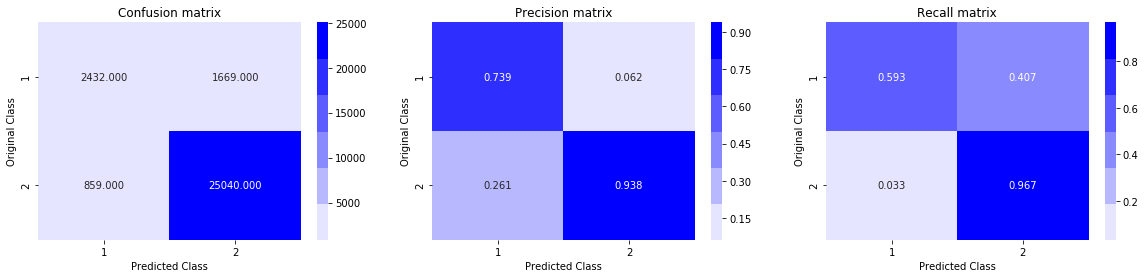

In [26]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score,recall_score,f1_score
clf = LogisticRegression(C= 0.05, penalty= 'l1')
clf.fit(X_train,y_train)
y_train_pred = clf.predict(X_train)
y_pred = clf.predict(X_test)
print("Accuracy on train set: %0.3f%%"%(accuracy_score(y_train, y_train_pred)*100))
print("Precision on train set: %0.3f"%(precision_score(y_train, y_train_pred)))
print("Recall on train set: %0.3f"%(recall_score(y_train, y_train_pred)))
print("F1-Score on train set: %0.3f"%(f1_score(y_train, y_train_pred,average='micro')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
plot_confusion_matrix(y_train, y_train_pred)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='micro')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
print('Confusion matrix for the model is:')
plot_confusion_matrix(y_test, y_pred)

Showing how sparsity increases as we increase lambda or decrease C when L1 Regularizer is used

In [27]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 1000, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='micro')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 84.600%
F1-Score on test set: 0.846
Non Zero weights: 19430


In [28]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 100, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='micro')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 84.740%
F1-Score on test set: 0.847
Non Zero weights: 17013


In [29]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='micro')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 85.710%
F1-Score on test set: 0.857
Non Zero weights: 17390


In [30]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 1, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='micro')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 88.003%
F1-Score on test set: 0.880
Non Zero weights: 18082


In [31]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 0.1, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='micro')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 90.887%
F1-Score on test set: 0.909
Non Zero weights: 15583


In [32]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 0.01, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='micro')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 91.660%
F1-Score on test set: 0.917
Non Zero weights: 5953




We can see how drastically the sparsity decreases from 19430 non-zero weights(@ C=1000) to only 5953 non-zero weights(@ C=0.01) when we use L1 Regularization


### Using Randomized Search CV to find best parameters

In [33]:
%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
#params we need to try on classifier
param_grid = { 'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
              'penalty':['l1','l2']}
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = RandomizedSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='f1_micro')
gsv.fit(X_train,y_train)
savetofile(gsv,"Log Reg/gsv_uni_r")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Wall time: 0 ns
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  6.5min finished


Best HyperParameter:  {'penalty': 'l2', 'C': 0.001}
Best Accuracy: 91.14%


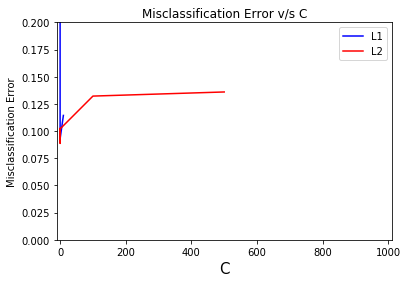

In [34]:
def plot_error_vs_c_r(gsv):
    x1=[]
    y1=[]
    x2=[]
    y2=[]
    for a in gsv.grid_scores_:
        if (a[0]['penalty']) == 'l1':
            y1.append(1-a[1])
            x1.append(a[0]['C'])
        else:
            y2.append(1-a[1])
            x2.append(a[0]['C'])

    ind1 = np.argsort(x1)
    x1=np.array(x1)
    y1=np.array(y1)
    ind2 = np.argsort(x2)
    x2=np.array(x2)
    y2=np.array(y2)
    plt.xlim(-10,1010)
    plt.ylim(0,0.2)
    plt.xlabel("C",fontsize=15)
    plt.ylabel("Misclassification Error")
    plt.title('Misclassification Error v/s C')
    plt.plot(x1[ind1],y1[ind1],'b',label="L1")
    plt.plot(x2[ind2],y2[ind2],'r',label="L2")
    plt.legend()
    plt.show()
gsv = openfromfile("Log Reg/gsv_uni_r")
plot_error_vs_c_r(gsv)

Accuracy on train set: 96.237%
Precision on train set: 0.960
Recall on train set: 0.999
F1-Score on train set: 0.962
Non Zero weights: 64925
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



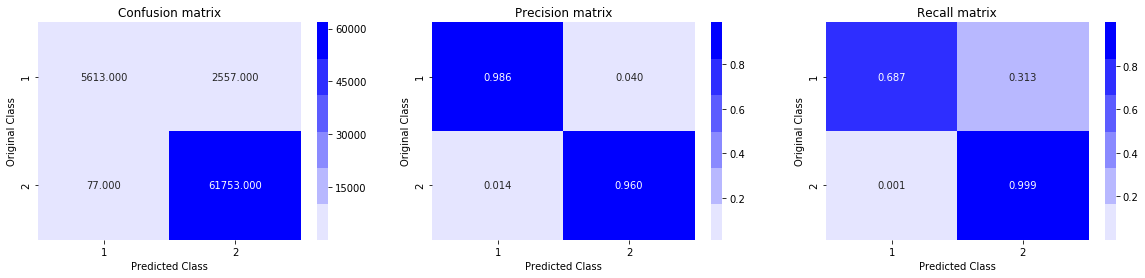

Accuracy on test set: 89.243%
Precision on test set: 0.897
Recall on test set: 0.988
F1-Score on test set: 0.892
Non Zero weights: 64925
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]

Confusion matrix for the model is:


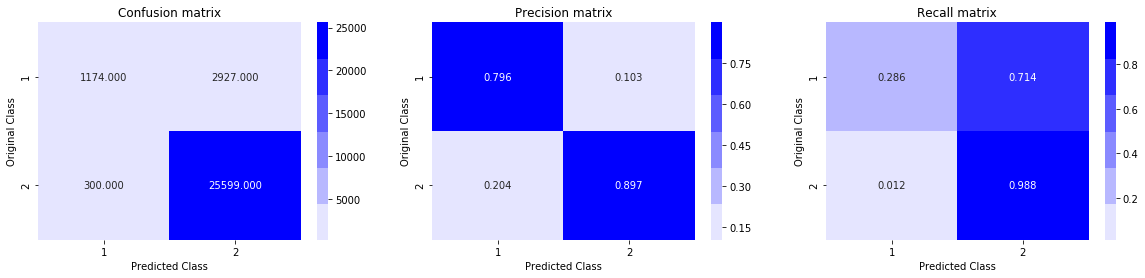

In [35]:
clf = LogisticRegression(C= 0.0001, penalty= 'l2')
clf.fit(X_train,y_train)
y_train_pred = clf.predict(X_train)
y_pred = clf.predict(X_test)
print("Accuracy on train set: %0.3f%%"%(accuracy_score(y_train, y_train_pred)*100))
print("Precision on train set: %0.3f"%(precision_score(y_train, y_train_pred)))
print("Recall on train set: %0.3f"%(recall_score(y_train, y_train_pred)))
print("F1-Score on train set: %0.3f"%(f1_score(y_train, y_train_pred,average='micro')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
plot_confusion_matrix(y_train, y_train_pred)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='micro')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
print('Confusion matrix for the model is:')
plot_confusion_matrix(y_test, y_pred)

## [7.2.4] Bi-Grams 

**Motivation**

Now that we have our list of words describing positive and negative reviews lets analyse them.<br>

We begin analysis by getting the frequency distribution of the words as shown below

In [36]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(final['CleanedText'].values,final['Score'].values,test_size=0.3,shuffle=False)

#taking one words and two consecutive words together
bi_gram = CountVectorizer(ngram_range=(1,2)) 
X_train = bi_gram.fit_transform(X_train)
#Normalize Data
X_train = preprocessing.normalize(X_train)

X_test = bi_gram.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X_train = sc.fit_transform(X_train)
X_test= sc.transform(X_test)
print("Train Data Size: ",X_train.shape)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (70000, 1003102)
Test Data Size:  (30000, 1003102)


In [37]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
#params we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='f1_micro')
gsv.fit(X_train,y_train)
savetofile(gsv,"Log Reg/gsv_bi")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Wall time: 0 ns
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 42.9min finished


Best HyperParameter:  {'C': 0.01, 'penalty': 'l1'}
Best Accuracy: 91.16%


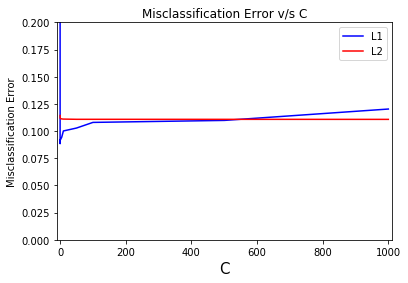

In [38]:
gsv = openfromfile("Log Reg/gsv_bi")
plot_error_vs_c(gsv)

Accuracy on train set: 99.963%
Precision on train set: 1.000
Recall on train set: 1.000
F1-Score on train set: 1.000
Non Zero weights: 27198
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



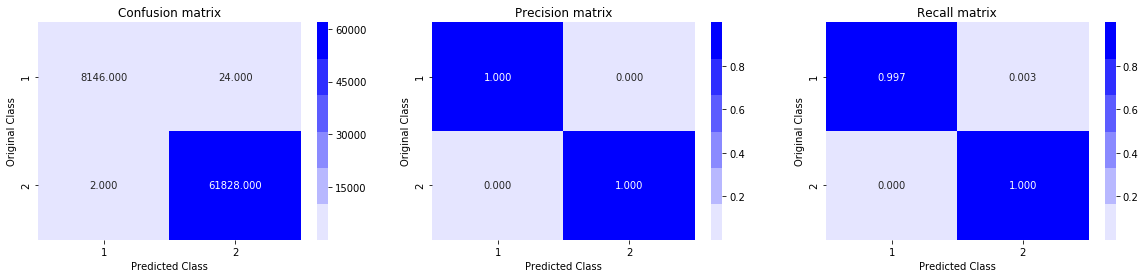

Accuracy on test set: 92.170%
Precision on test set: 0.929
Recall on test set: 0.985
F1-Score on test set: 0.922
Non Zero weights: 27198
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]

Confusion matrix for the model is:


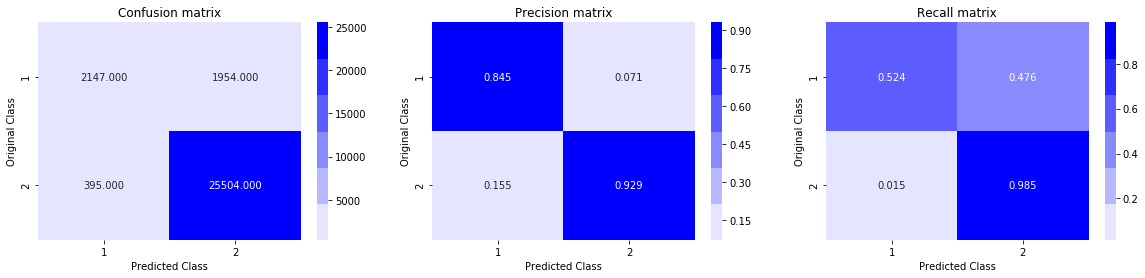

In [39]:
clf = LogisticRegression(C= 0.01, penalty= 'l1')
clf.fit(X_train,y_train)
y_train_pred = clf.predict(X_train)
y_pred = clf.predict(X_test)
print("Accuracy on train set: %0.3f%%"%(accuracy_score(y_train, y_train_pred)*100))
print("Precision on train set: %0.3f"%(precision_score(y_train, y_train_pred)))
print("Recall on train set: %0.3f"%(recall_score(y_train, y_train_pred)))
print("F1-Score on train set: %0.3f"%(f1_score(y_train, y_train_pred,average='micro')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
plot_confusion_matrix(y_train, y_train_pred)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='micro')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
print('Confusion matrix for the model is:')
plot_confusion_matrix(y_test, y_pred)

Showing how sparsity increases as we increase lambda or decrease C when L1 Regularizer is used

In [40]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 1000, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='micro')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 84.673%
F1-Score on test set: 0.847
Non Zero weights: 467782


In [41]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 100, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='micro')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 87.683%
F1-Score on test set: 0.877
Non Zero weights: 211933


In [42]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='micro')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 90.337%
F1-Score on test set: 0.903
Non Zero weights: 65503


In [43]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 1, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='micro')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 91.657%
F1-Score on test set: 0.917
Non Zero weights: 43566


In [44]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 0.1, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='micro')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 91.650%
F1-Score on test set: 0.916
Non Zero weights: 37455


In [45]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 0.01, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='micro')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 92.177%
F1-Score on test set: 0.922
Non Zero weights: 25153


We can see how drastically the sparsity decreases from 467782 non-zero weights(@ C=1000) to only 25153 non-zero weights(@ C=0.01) when we use L1 Regularization

### Using Randomized Search CV to find best parameters

In [46]:
%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
#params we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
              'penalty':['l1','l2']}
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = RandomizedSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='f1_micro')
gsv.fit(X_train,y_train)
savetofile(gsv,"Log Reg/gsv_bi_r")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Wall time: 0 ns
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 18.6min finished


Best HyperParameter:  {'penalty': 'l1', 'C': 0.01}
Best Accuracy: 91.16%


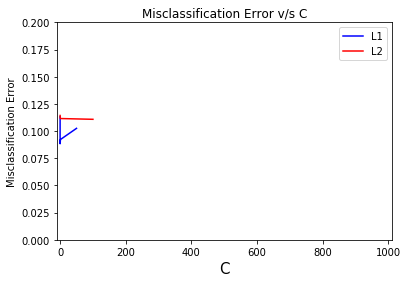

In [47]:
gsv = openfromfile("Log Reg/gsv_bi_r")
plot_error_vs_c_r(gsv)

Accuracy on train set: 99.963%
Precision on train set: 1.000
Recall on train set: 1.000
F1-Score on train set: 1.000
Non Zero weights: 25528
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



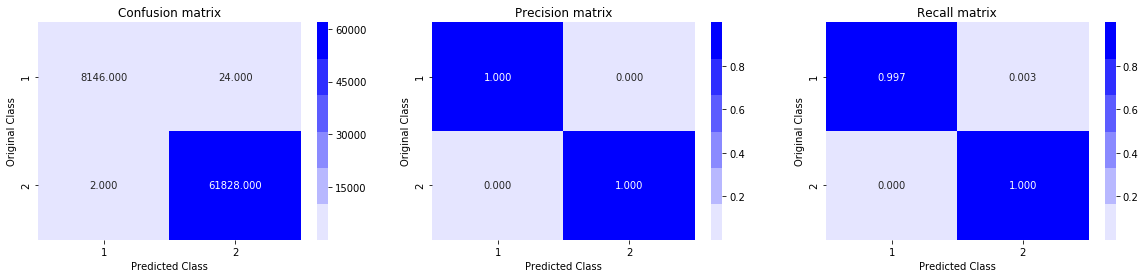

Accuracy on test set: 92.170%
Precision on test set: 0.929
Recall on test set: 0.985
F1-Score on test set: 0.922
Non Zero weights: 25528
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]

Confusion matrix for the model is:


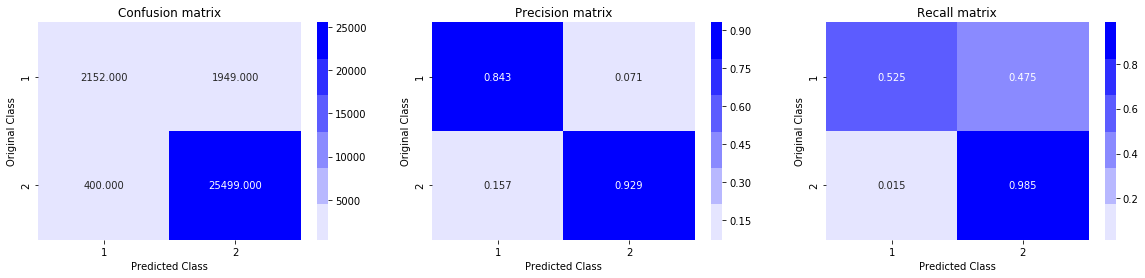

In [48]:
clf = LogisticRegression(C= 0.01, penalty= 'l1')
clf.fit(X_train,y_train)
y_train_pred = clf.predict(X_train)
y_pred = clf.predict(X_test)
print("Accuracy on train set: %0.3f%%"%(accuracy_score(y_train, y_train_pred)*100))
print("Precision on train set: %0.3f"%(precision_score(y_train, y_train_pred)))
print("Recall on train set: %0.3f"%(recall_score(y_train, y_train_pred)))
print("F1-Score on train set: %0.3f"%(f1_score(y_train, y_train_pred,average='micro')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
plot_confusion_matrix(y_train, y_train_pred)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='micro')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
print('Confusion matrix for the model is:')
plot_confusion_matrix(y_test, y_pred)

Perturbation Test

In [84]:
import scipy as sp
epsilon = sp.stats.distributions.norm.rvs(loc=0,scale=0.0001)
# Vector before the addition of epsilon
W_before_epsilon = clf.coef_

# Number of non zero elements in X_train_vec_standardized sparse matrix
no_of_non_zero = X_train.count_nonzero()

# Importing library to create a sparse matrix of epsilon
from scipy.sparse import csr_matrix

# Creating new sparse matrix with epsilon at same position of non-zero elements of X_train_vec_standardized
indices_X_train = X_train.indices
indptr_X_train = X_train.indptr

# Creating a list of same element with repetition
data = [epsilon] * no_of_non_zero
Shape = X_train.shape

# Creating sparse matrix
sparse_epsilon = csr_matrix((data,indices_X_train,indptr_X_train),shape=Shape,dtype=float)

# Add sparse_epsilon and X-train_vec_standardized to get a new sparse matrix with epsilon added to each 
# non-zero element of X_train_vec_standardized
epsilon_train = X_train + sparse_epsilon

print(X_train.shape)
print(epsilon_train.shape)

(70000, 1003102)
(70000, 1003102)


In [86]:
epsilon_lr = LogisticRegression(penalty='l1', C=0.01, n_jobs=-1)
epsilon_lr.fit(epsilon_train,y_train)

# Vector after the addition of epsilon
W_after_epsilon = epsilon_lr.coef_

# Change in vectors after adding epsilon
change_vector = W_after_epsilon - W_before_epsilon

# Sort this change_vector array after making all the elements positive in ascending order to visualize the change
sorted_change_vector = np.sort(np.absolute(change_vector))[:,::-1]

sorted_change_vector[0,0:20]

array([0.0177024 , 0.01069277, 0.01045934, 0.01036312, 0.00995046,
       0.00994137, 0.00987692, 0.00977656, 0.0096977 , 0.00931577,
       0.00919783, 0.00919306, 0.00918648, 0.0091204 , 0.00908224,
       0.00895077, 0.008722  , 0.00870868, 0.00864846, 0.0085583 ])

In [88]:
absolute_weights = np.absolute(W_before_epsilon)
sorted_absolute_index = np.argsort(absolute_weights)[:,::-1]
top_index = sorted_absolute_index[0,0:20]

all_features = bi_gram.get_feature_names()
weight_values = clf.coef_

# Top 20 features are    
print("Top 20 features with their weight values :")

for j in top_index:
    print("%12s\t--> \t%f"%(all_features[j],weight_values[0,j]))

Top 20 features with their weight values :
       great	--> 	0.683128
        best	--> 	0.472134
        love	--> 	0.463073
        good	--> 	0.369411
  disappoint	--> 	-0.360893
      delici	--> 	0.353219
     perfect	--> 	0.307629
       excel	--> 	0.272745
         not	--> 	-0.231705
     favorit	--> 	0.223190
        nice	--> 	0.211375
       worst	--> 	-0.207587
      wonder	--> 	0.197292
   not worth	--> 	-0.187525
        find	--> 	0.184926
     terribl	--> 	-0.176707
not disappoint	--> 	0.170614
high recommend	--> 	0.166500
       tasti	--> 	0.165060
          aw	--> 	-0.151817


# [7.2.5] TF-IDF

In [90]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(final['CleanedText'].values,final['Score'].values,test_size=0.3,shuffle=False)

tfidf = TfidfVectorizer() 
X_train = tfidf.fit_transform(X_train)
#Normalize Data
X_train = preprocessing.normalize(X_train)

X_test = tfidf.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
sc = StandardScaler(with_mean=False)
X_train = sc.fit_transform(X_train)
X_test= sc.transform(X_test)

print("Train Data Size: ",X_train.shape)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (70000, 64925)
Test Data Size:  (30000, 64925)
Wall time: 9.48 s


In [91]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

#params we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='f1_micro')
gsv.fit(X_train,y_train)
savetofile(gsv,"Log Reg/gsv_tfidf")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Wall time: 0 ns
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 101.7min finished


Best HyperParameter:  {'C': 0.05, 'penalty': 'l1'}
Best Accuracy: 91.65%


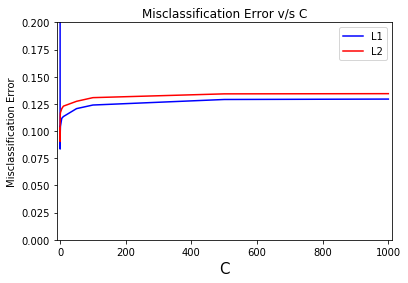

In [92]:
gsv = openfromfile("Log Reg/gsv_tfidf")
plot_error_vs_c(gsv)

Accuracy on train set: 98.510%
Precision on train set: 0.987
Recall on train set: 0.996
F1-Score on train set: 0.985
Non Zero weights: 14008
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



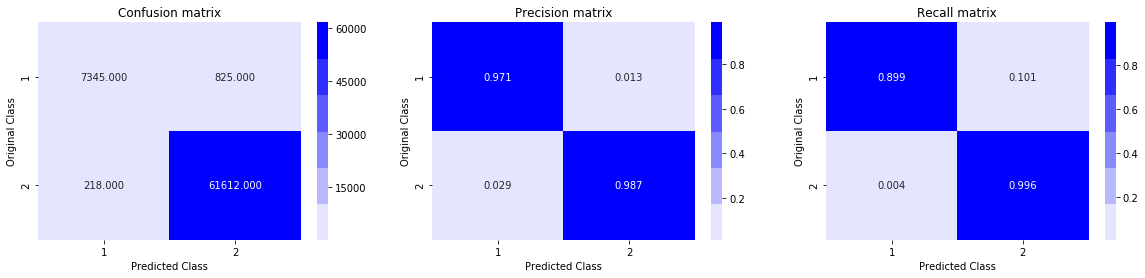

Accuracy on test set: 91.393%
Precision on test set: 0.935
Recall on test set: 0.967
F1-Score on test set: 0.914
Non Zero weights: 14008
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]

Confusion matrix for the model is:


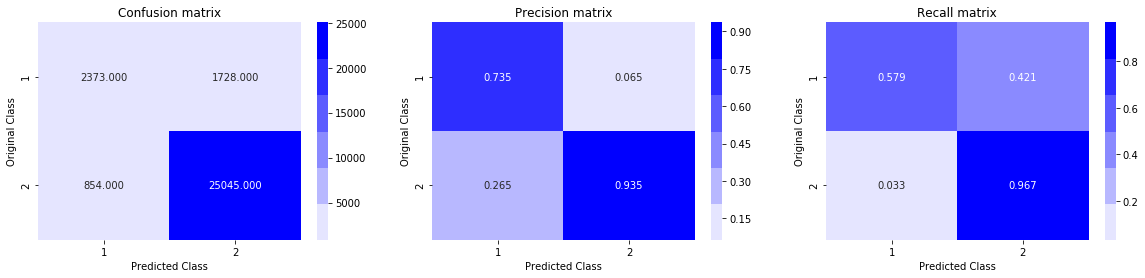

In [93]:
clf = LogisticRegression(C= 0.05, penalty= 'l1')
clf.fit(X_train,y_train)
y_train_pred = clf.predict(X_train)
y_pred = clf.predict(X_test)
print("Accuracy on train set: %0.3f%%"%(accuracy_score(y_train, y_train_pred)*100))
print("Precision on train set: %0.3f"%(precision_score(y_train, y_train_pred)))
print("Recall on train set: %0.3f"%(recall_score(y_train, y_train_pred)))
print("F1-Score on train set: %0.3f"%(f1_score(y_train, y_train_pred,average='micro')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
plot_confusion_matrix(y_train, y_train_pred)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='micro')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
print('Confusion matrix for the model is:')
plot_confusion_matrix(y_test, y_pred)

Showing how sparsity increases as we increase lambda or decrease C when L1 Regularizer is use

In [103]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 1000, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='micro')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 84.490%
F1-Score on test set: 0.845
Non Zero weights: 24250


In [105]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 100, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='micro')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 84.697%
F1-Score on test set: 0.847
Non Zero weights: 19858


In [106]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='micro')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 85.553%
F1-Score on test set: 0.856
Non Zero weights: 17594


In [107]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 1, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='micro')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 87.723%
F1-Score on test set: 0.877
Non Zero weights: 18521


In [108]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 0.1, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='micro')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 90.703%
F1-Score on test set: 0.907
Non Zero weights: 16211


In [109]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 0.01, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='micro')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 91.597%
F1-Score on test set: 0.916
Non Zero weights: 6124



We can see how drastically the sparsity increases from 24250 non-zero weights(@ C=1000) to only 3 non-zero weights(@ C=0.01) when we use L1 Regularization


### Regularization Using Randomized Search CV to find best parameters

In [100]:
%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
#params we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
              ,'penalty':['l1','l2']}
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = RandomizedSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='f1_micro')
gsv.fit(X_train,y_train)
savetofile(gsv,"Log Reg/gsv_tfidf_r")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Wall time: 0 ns
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  7.7min finished


Best HyperParameter:  {'penalty': 'l1', 'C': 0.05}
Best Accuracy: 91.65%


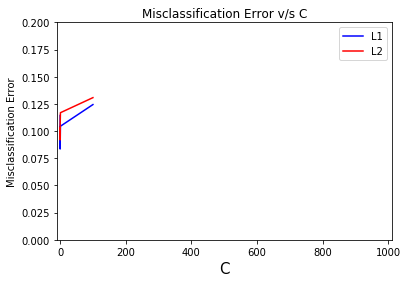

In [101]:
gsv = openfromfile("Log Reg/gsv_tfidf_r")
plot_error_vs_c_r(gsv)

Accuracy on train set: 98.513%
Precision on train set: 0.987
Recall on train set: 0.996
F1-Score on train set: 0.985
Non Zero weights: 13903
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



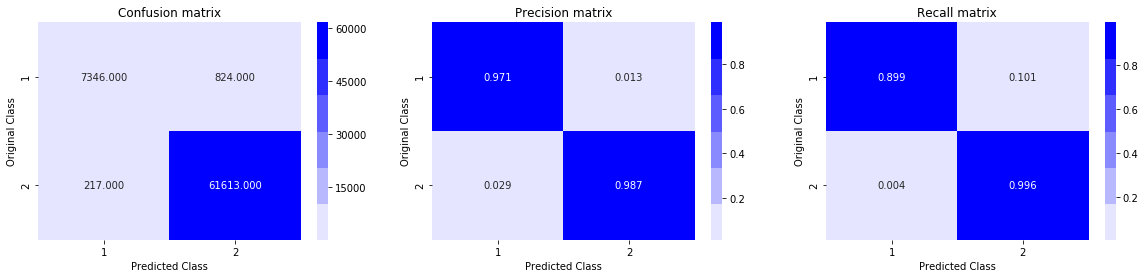

Accuracy on test set: 91.390%
Precision on test set: 0.936
Recall on test set: 0.967
F1-Score on test set: 0.914
Non Zero weights: 13903
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]

Confusion matrix for the model is:


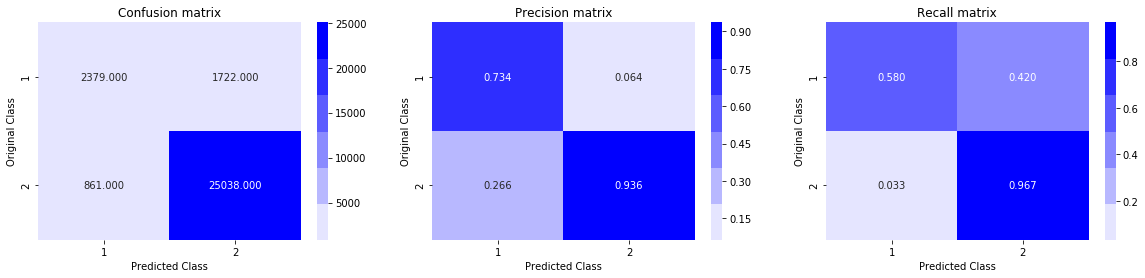

In [102]:
clf = LogisticRegression(C= 0.05, penalty= 'l1')
clf.fit(X_train,y_train)
y_train_pred = clf.predict(X_train)
y_pred = clf.predict(X_test)
print("Accuracy on train set: %0.3f%%"%(accuracy_score(y_train, y_train_pred)*100))
print("Precision on train set: %0.3f"%(precision_score(y_train, y_train_pred)))
print("Recall on train set: %0.3f"%(recall_score(y_train, y_train_pred)))
print("F1-Score on train set: %0.3f"%(f1_score(y_train, y_train_pred,average='micro')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
plot_confusion_matrix(y_train, y_train_pred)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='micro')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
print('Confusion matrix for the model is:')
plot_confusion_matrix(y_test, y_pred)

Perturbation Test

In [110]:
import scipy as sp
epsilon = sp.stats.distributions.norm.rvs(loc=0,scale=0.0001)
# Vector before the addition of epsilon
W_before_epsilon = clf.coef_

# Number of non zero elements in X_train_vec_standardized sparse matrix
no_of_non_zero = X_train.count_nonzero()

# Importing library to create a sparse matrix of epsilon
from scipy.sparse import csr_matrix

# Creating new sparse matrix with epsilon at same position of non-zero elements of X_train_vec_standardized
indices_X_train = X_train.indices
indptr_X_train = X_train.indptr

# Creating a list of same element with repetition
data = [epsilon] * no_of_non_zero
Shape = X_train.shape

# Creating sparse matrix
sparse_epsilon = csr_matrix((data,indices_X_train,indptr_X_train),shape=Shape,dtype=float)

# Add sparse_epsilon and X-train_vec_standardized to get a new sparse matrix with epsilon added to each 
# non-zero element of X_train_vec_standardized
epsilon_train = X_train + sparse_epsilon

print(X_train.shape)
print(epsilon_train.shape)

(70000, 64925)
(70000, 64925)


In [111]:
epsilon_lr = LogisticRegression(penalty='l1', C=0.05, n_jobs=-1)
epsilon_lr.fit(epsilon_train,y_train)

# Vector after the addition of epsilon
W_after_epsilon = epsilon_lr.coef_

# Change in vectors after adding epsilon
change_vector = W_after_epsilon - W_before_epsilon

# Sort this change_vector array after making all the elements positive in ascending order to visualize the change
sorted_change_vector = np.sort(np.absolute(change_vector))[:,::-1]

sorted_change_vector[0,0:20]

array([0.20545409, 0.18718968, 0.16820735, 0.16599216, 0.14544775,
       0.14533518, 0.13881392, 0.13196279, 0.12740095, 0.12252001,
       0.12242056, 0.1218007 , 0.11695892, 0.11260441, 0.11123762,
       0.11024841, 0.10760662, 0.10624811, 0.10495961, 0.10492818])

In [112]:
absolute_weights = np.absolute(W_before_epsilon)
sorted_absolute_index = np.argsort(absolute_weights)[:,::-1]
top_index = sorted_absolute_index[0,0:20]

all_features =tfidf.get_feature_names()
weight_values = clf.coef_

# Top 20 features are    
print("Top 20 features with their weight values :")

for j in top_index:
    print("%12s\t--> \t%f"%(all_features[j],weight_values[0,j]))

Top 20 features with their weight values :
       great	--> 	0.684374
        best	--> 	0.519821
        love	--> 	0.461286
      delici	--> 	0.393307
     perfect	--> 	0.367119
         not	--> 	-0.361515
        good	--> 	0.331659
       excel	--> 	0.313476
        nice	--> 	0.253738
     favorit	--> 	0.243472
  disappoint	--> 	-0.234664
        find	--> 	0.219518
      wonder	--> 	0.217783
       worst	--> 	-0.208236
       tasti	--> 	0.177924
        amaz	--> 	0.176945
        keep	--> 	0.169720
      addict	--> 	0.156525
     terribl	--> 	-0.152146
       yummi	--> 	0.145016


# [7.2.6] Word2Vec

In [113]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need
is_your_ram_gt_16g=False
want_to_read_sub_set_of_google_w2v = True
want_to_read_whole_google_w2v = True
if not is_your_ram_gt_16g:
    if want_to_read_sub_set_of_google_w2v and  os.path.isfile('google_w2v_for_amazon.pkl'):
        with open('google_w2v_for_amazon.pkl', 'rb') as f:
            # model is dict object, you can directly access any word vector using model[word]
            model = pickle.load(f)
else:
    if want_to_read_whole_google_w2v and os.path.isfile('GoogleNews-vectors-negative300.bin'):
        model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

# print("the vector representation of word 'computer'",model.wv['computer'])
# print("the similarity between the words 'woman' and 'man'",model.wv.similarity('woman', 'man'))
# print("the most similar words to the word 'woman'",model.wv.most_similar('woman'))
# this will raise an error
# model.wv.most_similar('tasti')  # "tasti" is the stemmed word for tasty, tastful

In [19]:
final_string = []
for sent in final['CleanedText'].values:
    sent = str(sent)
    sentence=[]
#     print(sent)
    for word in sent.split():
#         print(word)
        sentence.append(word)
#         print(sentence)
    final_string.append(sentence)

In [20]:
%%time
# Train your own Word2Vec model using your own text corpus
import gensim

w2v_model=gensim.models.Word2Vec(final_string,min_count=5,size=50, workers=-1)
#min-count: Ignoring the words which occurs less than 5 times
#size:Creating vectors of size 50 for each word
#workers: Use these many worker threads to train the model (faster training with multicore machines)

Wall time: 4.37 s


In [21]:
w2v_model.save('w2vmodel')

In [22]:
w2v_model = gensim.models.Word2Vec.load('w2vmodel')

In [23]:
w2v_words = list(w2v_model.wv.vocab)

In [24]:
w2v_vocub = w2v_model.wv.vocab
len(w2v_vocub)

16909

In [25]:
w2v_model.wv.most_similar('like')

[('alabama', 0.48587822914123535),
 ('creek', 0.48546063899993896),
 ('crown', 0.47647255659103394),
 ('coffeenot', 0.47441166639328003),
 ('rachel', 0.46372172236442566),
 ('cleanser', 0.4460267424583435),
 ('upright', 0.4457867443561554),
 ('fazer', 0.4450550377368927),
 ('elder', 0.44065648317337036),
 ('twirl', 0.4406422972679138)]

avg w2c

In [26]:
%%time
avg_vec = [] #List to store all the avg w2vec's 
for sent in final_string[0:1]:
    cnt = 0 #to count no of words in each reviews
    sent_vec = np.zeros(50) #Initializing with zeroes
    print("sent:",sent) 
    for word in sent:
        try:
            wvec = w2v_model.wv[word] #Vector of each using w2v model
            print("wvec:",wvec)
            sent_vec += wvec #Adding the vectors 
            cnt += 1
        except: 
            pass #When the word is not in the dictionary then do nothing 
    print("sent_vec:",sent_vec)    
    a_vec =sent_vec / cnt #Taking average of vectors sum of the particular review
    print("avg_vec:",a_vec)
    avg_vec.append(a_vec) #Storing the avg w2vec's for each review
    print("*******************************************************************")

sent: ["b'witti", 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'recit', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'love', 'new', 'word', 'book', 'introduc', 'silli', 'classic', 'book', 'will', 'bet', 'son', 'still', 'abl', 'recit', 'memori', "colleg'"]
wvec: [ 0.00927044  0.00268178 -0.00347884 -0.00993292  0.00485403 -0.00693354
 -0.00206989  0.00108701  0.00409818 -0.00782471  0.00949951  0.00545466
 -0.00430164 -0.00083933 -0.00801887 -0.00657124  0.00879726  0.00099144
  0.00530099 -0.00108125 -0.00536537  0.00178298 -0.00106748  0.00753624
 -0.00535857 -0.00839065 -0.00351354  0.00754232  0.00982998  0.00291407
 -0.00958644 -0.00290739  0.00253408 -0.00085875 -0.00593013 -0.00779566
  0.0021525  -0.00535808 -0.00353203 -0.00941841 -0.00127577 -0.00498264
 -0.00182707  0.00336423  0.00300162  0.00791903  0.00984028 -0.00442397
 -0.00916059  0.00627346]
wvec: [-5.4075806e-03 -5.0162775e-03  5.9144095e-05 -3.2706622e-03
 -6.07

 -0.00973644 -0.0096125 ]
wvec: [ 0.00986554 -0.00450705  0.00807562 -0.00216536  0.00673817 -0.00880115
  0.00284593  0.00233731 -0.0033623  -0.00395001 -0.0036175  -0.00463511
 -0.00647157  0.0092606   0.00330525 -0.00645051 -0.00596749  0.00383129
 -0.00582228  0.00147761 -0.00830651 -0.00748687 -0.00797166  0.00342711
 -0.00967473 -0.0008066  -0.00570415 -0.00376743  0.0074602  -0.00758024
 -0.00981444 -0.00425747  0.00176709  0.00882637  0.00473261 -0.00810418
  0.00821655  0.00927105 -0.00467919 -0.00520035  0.00057835 -0.0002992
  0.00455789  0.00850039  0.00596271  0.00246602  0.00204089  0.00481999
  0.00256289 -0.0094123 ]
wvec: [ 0.00389263 -0.00629011  0.00159797 -0.00494733 -0.00956007  0.00839765
  0.0024793  -0.00702135  0.00785211  0.00746952 -0.00206816 -0.00374402
  0.00706421 -0.00377411 -0.00133309 -0.00431209  0.00514586  0.00950797
  0.00662718 -0.00449218 -0.00506961  0.00579981 -0.0002921   0.0084784
 -0.00988916  0.00020795 -0.0071886   0.00530585  0.00749199  

  4.8217303e-03 -2.3909414e-03]
wvec: [-0.0088635  -0.00181669 -0.00750914  0.0020975   0.00410485 -0.0026987
 -0.0063842  -0.00637401  0.00331545 -0.00745189  0.00802469  0.00311782
 -0.00443397  0.00070879 -0.00992415 -0.00167638 -0.00828051  0.00232862
  0.00153729  0.00389894 -0.0039066  -0.00838301 -0.00586387 -0.00841817
  0.00414113 -0.00240484 -0.00727162 -0.00301679  0.00732025 -0.00357601
 -0.00092371  0.00918195 -0.00330372  0.00815441  0.00823865 -0.00136043
 -0.00993572 -0.00696717 -0.00122623 -0.00892034 -0.00908525 -0.00822044
 -0.00237947 -0.00941831 -0.00916047  0.00836572  0.00643965  0.0093693
 -0.00332231 -0.00784314]
wvec: [-0.00506467  0.00410486  0.00095662  0.00304894  0.00189249 -0.00543701
 -0.00809109  0.00443681  0.00555901  0.00888877  0.00212239  0.00866253
  0.00763566  0.00603846  0.00082356  0.00236644 -0.00835424 -0.00411495
  0.00943898 -0.0031987   0.00725016 -0.00425156 -0.00491978 -0.00444182
  0.00157724  0.0002719  -0.00033978  0.00993893 -0.0009

In [27]:
%%time
np.seterr(divide='ignore', invalid='ignore')
avg_vec = [] #List to store all the avg w2vec's 
for sent in final_string:
    cnt = 0 #to count no of words in each reviews
    sent_vec = np.zeros(50) #Initializing with zeroes
    for word in sent:
        try:
            wvec = w2v_model.wv[word] #Vector of each using w2v model
            sent_vec += wvec #Adding the vectors 
            cnt += 1
        except: 
            pass #When the word is not in the dictionary then do nothing 
    sent_vec /= cnt #Taking average of vectors sum of the particular review
    avg_vec.append(sent_vec) #Storing the avg w2vec's for each review
    #print("*******************************************************************")
    # Average Word2Vec

Wall time: 41.3 s


In [28]:
savetofile(avg_vec,"avg_w2v_vec")

In [29]:
avg_vec = openfromfile("avg_w2v_vec")

In [30]:
avg_vec = np.array(avg_vec)
avg_vec.shape

(100000, 50)

In [31]:
np.isnan(avg_vec).any()

True

In [32]:
mask = ~np.any(np.isnan(avg_vec), axis=1)
# print(mask)
avg_vec_new = avg_vec[mask]
final_sample_new = final['Score'][mask]
print(avg_vec_new.shape)
print(final_sample_new.shape)

(99996, 50)
(99996,)


In [174]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
#Normalizing the data
avg_vec_norm = preprocessing.normalize(avg_vec_new)

#Not shuffling the data as we want it on time basis
X_train, X_test, y_train, y_test = train_test_split(avg_vec_norm,final_sample_new.values,test_size=0.3,shuffle=False)
sc = StandardScaler(with_mean=False)
X_train = sc.fit_transform(X_train)
X_test= sc.transform(X_test)

print("Train Data Size: ",X_train.shape)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (69997, 50)
Test Data Size:  (29999, 50)


In [131]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
#params we need to try on classifier
param_grid = {'C':[100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='f1_micro')
gsv.fit(X_train,y_train)
savetofile(gsv,"Log Reg/gsv_w2v")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Wall time: 0 ns
Fitting 10 folds for each of 26 candidates, totalling 260 fits


[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:  1.2min finished


Best HyperParameter:  {'C': 0.1, 'penalty': 'l2'}
Best Accuracy: 88.34%


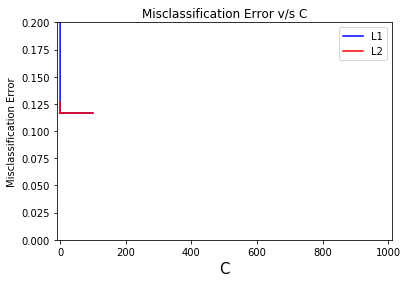

In [132]:
gsv = openfromfile("Log Reg/gsv_w2v")
plot_error_vs_c(gsv)

Accuracy on train set: 88.341%
Precision on train set: 0.884
Recall on train set: 1.000
F1-Score on train set: 0.883
Non Zero weights: 50
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



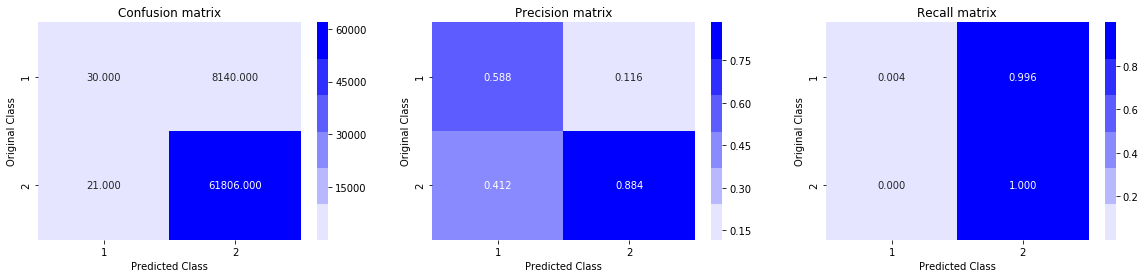

Accuracy on test set: 86.360%
Precision on test set: 0.864
Recall on test set: 1.000
F1-Score on test set: 0.864
Non Zero weights: 50
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]

Confusion matrix for the model is:


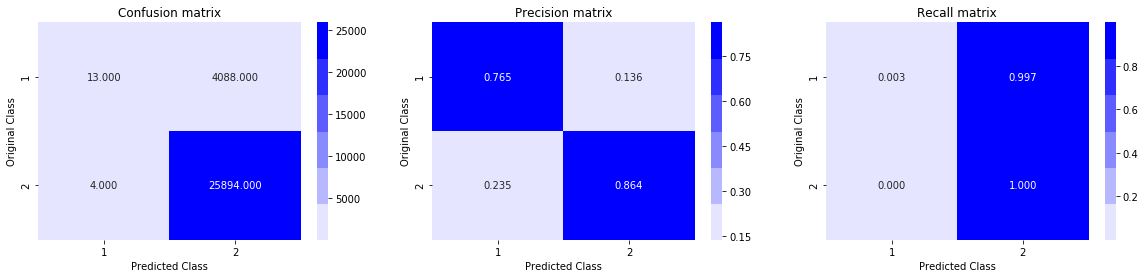

In [133]:
clf = LogisticRegression(C= 0.1, penalty= 'l2')
clf.fit(X_train,y_train)
y_train_pred = clf.predict(X_train)
y_pred = clf.predict(X_test)
print("Accuracy on train set: %0.3f%%"%(accuracy_score(y_train, y_train_pred)*100))
print("Precision on train set: %0.3f"%(precision_score(y_train, y_train_pred)))
print("Recall on train set: %0.3f"%(recall_score(y_train, y_train_pred)))
print("F1-Score on train set: %0.3f"%(f1_score(y_train, y_train_pred,average='micro')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
plot_confusion_matrix(y_train, y_train_pred)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='micro')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
print('Confusion matrix for the model is:')
plot_confusion_matrix(y_test, y_pred)

Using Randomized Search CV to find best parameter

In [134]:
%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
#params we need to try on classifier
param_grid = {'C': [100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
              ,'penalty':['l1','l2']}
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = RandomizedSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='f1_micro')
gsv.fit(X_train,y_train)
savetofile(gsv,"Log Reg/gsv_w2v_r")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Wall time: 0 ns
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   24.8s finished


Best HyperParameter:  {'penalty': 'l2', 'C': 100}
Best Accuracy: 88.34%


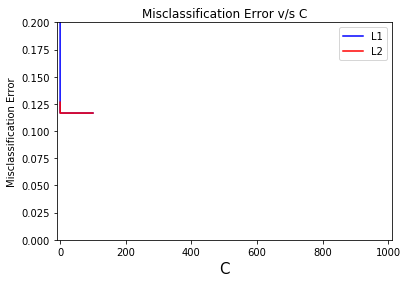

In [135]:
gsv = openfromfile("Log Reg/gsv_w2v_r")
plot_error_vs_c_r(gsv)

Accuracy on train set: 88.341%
Precision on train set: 0.884
Recall on train set: 1.000
F1-Score on train set: 0.883
Non Zero weights: 50
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



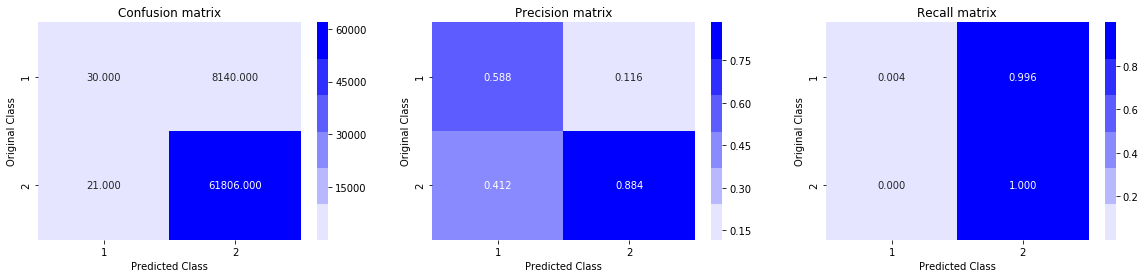

Accuracy on test set: 86.360%
Precision on test set: 0.864
Recall on test set: 1.000
F1-Score on test set: 0.864
Non Zero weights: 50
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]

Confusion matrix for the model is:


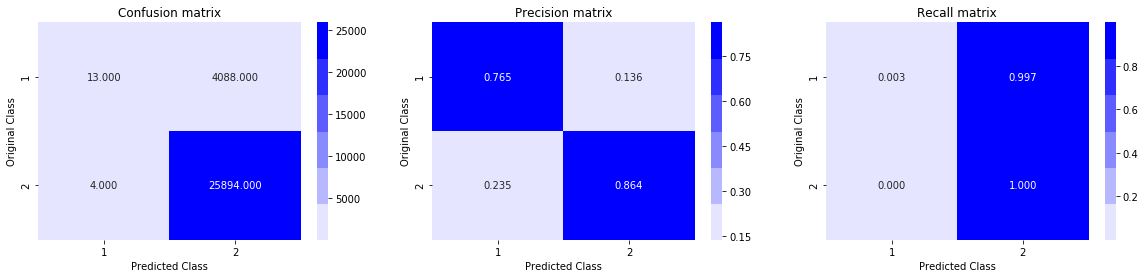

In [136]:
clf = LogisticRegression(C= 100, penalty= 'l2')
clf.fit(X_train,y_train)
y_train_pred = clf.predict(X_train)
y_pred = clf.predict(X_test)
print("Accuracy on train set: %0.3f%%"%(accuracy_score(y_train, y_train_pred)*100))
print("Precision on train set: %0.3f"%(precision_score(y_train, y_train_pred)))
print("Recall on train set: %0.3f"%(recall_score(y_train, y_train_pred)))
print("F1-Score on train set: %0.3f"%(f1_score(y_train, y_train_pred,average='micro')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
plot_confusion_matrix(y_train, y_train_pred)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='micro')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
print('Confusion matrix for the model is:')
plot_confusion_matrix(y_test, y_pred)

In [192]:
import re
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    sentence = sentence.decode('utf-8')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [34]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(final['CleanedText'].values,final['Score'].values,test_size=0.3,shuffle=False)

In [35]:
print ("Training Set - ", X_train.shape)
print ("Test Set - ", X_test.shape)

Training Set -  (70000,)
Test Set -  (30000,)


In [36]:
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(X_train)

In [37]:
i=0
list_of_sent=[]
for sent in X_train:
    list_of_sent.append(sent.split())
    
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

TypeError: can't concat str to bytes

In [ ]:
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

X_train_tfidfw2v = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_train_tfidfw2v.append(sent_vec)
    row += 1

In [ ]:
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(X_test)

In [ ]:
i=0
list_of_sent=[]
for sent in X_test:
    list_of_sent.append(sent.split())
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

In [ ]:
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

X_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_test.append(sent_vec)
    row += 1

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X_train_tfidfw2v_vec = sc.fit_transform(X_train_tfidfw2v)
X_test_tfidfw2v_vec = sc.transform(X_test)

In [ ]:
#To show how Time Series Split splits the data
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)
for train, cv in tscv.split(X_train_tfidfw2v_vec):
#     print("%s %s" % (train, cv))
    print(X_train_tfidfw2v_vec[train].shape, X_train_tfidfw2v_vec[cv].shape)

grid

In [207]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
#params we need to try on classifier
param_grid = {'C':[100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='f1_micro')
gsv.fit(X_train_tfidfw2v_vec,y_train)
savetofile(gsv,"Log Reg/gsv_w2v")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Wall time: 0 ns


ValueError: Found input variables with inconsistent numbers of samples: [30000, 70000]

Showing how sparsity increases as we increase lambda or decrease C when L1 Regularizer is used

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 1000, penalty= 'l1')
clf.fit(X_train_tfidfw2v_vec,y_train)
y_pred = clf.predict(X_train_tfidfw2v_vec)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='micro')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 100, penalty= 'l1')
clf.fit(X_train_tfidfw2v_vec,y_train)
y_pred = clf.predict(X_train_tfidfw2v_vec)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='micro')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l1')
clf.fit(X_train_tfidfw2v_vec,y_train)
y_pred = clf.predict(X_train_tfidfw2v_vec)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='micro')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 1, penalty= 'l1')
clf.fit(X_train_tfidfw2v_vec,y_train)
y_pred = clf.predict(X_train_tfidfw2v_vec)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='micro')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 0.1, penalty= 'l1')
clf.fit(X_train_tfidfw2v_vec,y_train)
y_pred = clf.predict(X_train_tfidfw2v_vec)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='micro')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 0.01, penalty= 'l1')
clf.fit(X_train_tfidfw2v_vec,y_train)
y_pred = clf.predict(X_train_tfidfw2v_vec)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='micro')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

We can see how drastically the sparsity decreases from 19430 non-zero weights(@ C=1000) to only 5953 non-zero weights(@ C=0.01) when we use L1 Regularization

# Randomized Search CV

In [ ]:
%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
#params we need to try on classifier
param_grid = { 'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
              'penalty':['l1','l2']}
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = RandomizedSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='f1_micro')
gsv.fit(X_train_tfidfw2v_vec,y_train)
savetofile(gsv,"Log Reg/gsv_uni_r")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

In [ ]:
clf = LogisticRegression(C= 0.0001, penalty= 'l2')
clf.fit(X_train_tfidfw2v_vec,y_train)
y_train_pred = clf.predict(X_train)
y_pred = clf.predict(X_train_tfidfw2v_vec)
print("Accuracy on train set: %0.3f%%"%(accuracy_score(y_train, y_train_pred)*100))
print("Precision on train set: %0.3f"%(precision_score(y_train, y_train_pred)))
print("Recall on train set: %0.3f"%(recall_score(y_train, y_train_pred)))
print("F1-Score on train set: %0.3f"%(f1_score(y_train, y_train_pred,average='micro')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
plot_confusion_matrix(y_train, y_train_pred)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='micro')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
print('Confusion matrix for the model is:')
plot_confusion_matrix(y_test, y_pred)

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range=(1,2)) #Using bi-grams
tfidf_vec_ns = tfidf.fit_transform(final['CleanedText_NoStem'].values)

#Saving the variable to access later without recomputing
# savetofile(tfidf_vec,"tfidf")

#Loading the variable from file
# tfidf_vec = openfromfile("tfidf")

print(tfidf_vec_ns.shape)

# tf-idf came up with 2.9 million features for the data corpus
from sklearn.decomposition import TruncatedSVD

tsvd_tfidf_ns = TruncatedSVD(n_components=300)#No of components as total dimensions
tsvd_tfidf_vec_ns = tsvd_tfidf_ns.fit_transform(tfidf_vec_ns)
print(tsvd_tfidf_ns.explained_variance_ratio_[:].sum())
features = tfidf.get_feature_names()

ValueError: empty vocabulary; perhaps the documents only contain stop words

In [7]:
con = sqlite3.connect("final.sqlite")#Connection object that represents the database

#Using pandas functions to query from sql table
final = pd.read_sql_query("""
SELECT * FROM Reviews 
""",con)

#Reviews is the name of the table given
#Taking only the data where score != 3 as score 3 will be neutral and it won't help us much
final.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


In [8]:
final1 =  final.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep="first")

In [9]:
size_diff = final1['Id'].size/final['Id'].size
print("%.1f %% reduction in data after deleting duplicates"%((1-size_diff)*100))
print("Size of data",final1['Id'].size," rows ")

0.0 % reduction in data after deleting duplicates
Size of data 364171  rows 


In [11]:
import re #Regex (Regualar Expr Operations)
#string = r"sdfsdfd" :- r is for raw string as Regex often uses \ backslashes(\w), so they are often raw strings(r’\d’)

########Function to remove html tags from data
def striphtml(data):
    p = re.compile('<.*?>')#Find this kind of pattern
#     print(p.findall(data))#List of strings which follow the regex pattern
    return p.sub('',data) #Substitute nothing at the place of strings which matched the patterns

striphtml('<a href="foo.com" class="bar">I Want This <b>text!</b></a><>')

'I Want This text!'

In [12]:
def strippunc(data):
    p = re.compile(r'[?|!|\'|"|#|.|,|)|(|\|/|~|%|*]')
    return p.sub('',data)
strippunc("fsd*?~,,,( sdfsdfdsvv)#")

'fsd sdfsdfdsvv'

In [13]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = stopwords.words('english') #All the stopwords in English language
#excluding some useful words from stop words list as we doing sentiment analysis
excluding = ['against','not','don', "don't",'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't",
             'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 
             'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't",'shouldn', "shouldn't", 'wasn',
             "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
stop = [words for words in stop if words not in excluding]
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's',

In [14]:
from nltk.stem import SnowballStemmer
snow = SnowballStemmer('english') #initialising the snowball stemmer
print("Stem/Root words of the some of the words using SnowBall Stemmer:")
print(snow.stem('tasty'))
print(snow.stem('tasteful'))
print(snow.stem('tastiest'))
print(snow.stem('delicious'))
print(snow.stem('amazing'))
print(snow.stem('amaze'))
print(snow.stem('initialize'))
print(snow.stem('fabulous'))
print(snow.stem('Honda City'))
print(snow.stem('unpleasant'))

Stem/Root words of the some of the words using SnowBall Stemmer:
tasti
tast
tastiest
delici
amaz
amaz
initi
fabul
honda c
unpleas


In [16]:
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final1['Text'][2:3].values: #Running only for 2nd review
    filtered_sentence=[]
    print(sent) #Each review
    sent=striphtml(sent)# remove HTMl tags
    sent=strippunc(sent)# remove Punctuation Symbols
    print(sent.split())
    for w in sent.split():
        print("================================>",w)
        if((w.isalpha()) and (len(w)>2)):#If it is a numerical value or character of lenght less than 2    
            if(w.lower() not in stop):# If it is a stopword
                s=(snow.stem(w.lower())).encode('utf8') #Stemming the word using SnowBall Stemmer
                print("Selected: Stem Word->",s)
                filtered_sentence.append(s)
            else:
                print("Eliminated as it is a stopword")
                continue
        else:
            print("Eliminated as it is a numerical value or character of lenght less than 2")
            continue 
#     print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    final_string.append(str1)
    print("***********************************************************************")
    print("Finally selected words from the review:\n",final_string)

This is a fun way for children to learn their months of the year!  We will learn all of the poems throughout the school year.  they like the handmotions which I invent for each poem.
['This', 'is', 'a', 'fun', 'way', 'for', 'children', 'to', 'learn', 'their', 'months', 'of', 'the', 'year', 'We', 'will', 'learn', 'all', 'of', 'the', 'poems', 'throughout', 'the', 'school', 'year', 'they', 'like', 'the', 'handmotions', 'which', 'I', 'invent', 'for', 'each', 'poem']
================================> This
Eliminated as it is a stopword
================================> is
Eliminated as it is a numerical value or character of lenght less than 2
================================> a
Eliminated as it is a numerical value or character of lenght less than 2
================================> fun
Selected: Stem Word-> b'fun'
================================> way
Selected: Stem Word-> b'way'
================================> for
Eliminated as it is a stopword
================================> childre

In [20]:
import time
# Code takes a while to run as it needs to run on around 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final1['Text'].values:
    filtered_sentence=[]
#     print(sent) #Each review
    sent=striphtml(sent)# remove HTMl tags
    sent=strippunc(sent)# remove Punctuation Symbols
#     print(sent.split())
    for w in sent.split():
#         print("================================>",w)
        if((w.isalpha()) and (len(w)>2)):#If it is a numerical value or character of lenght less than 2    
            if(w.lower() not in stop):# If it is a stopword
                s=(snow.stem(w.lower())).encode('utf8') #Stemming the word using SnowBall Stemmer
                                        #encoding as byte-string/utf-8
#                 print("Selected: Stem Word->",s)
                filtered_sentence.append(s)
                if (final1['Score'].values)[i] == 'Positive': 
                    all_positive_words.append(s) #list of all words used to describe positive reviews
                if(final1['Score'].values)[i] == 'Negative':
                    all_negative_words.append(s) #list of all words used to describe negative reviews reviews
            else:
#                 print("Eliminated as it is a stopword")
                continue
        else:
#             print("Eliminated as it is a numerical value or character of lenght less than 2")
            continue 
#     print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
            #encoding as byte-string/utf-8
    
    final_string.append(str1)
#     print("***********************************************************************")
#     print("Finally selected words from the review:\n",final_string)
    i+=1
print("Preprocessing completed in ")

Preprocessing completed in 


In [22]:
%%time
# Code takes a while to run as it needs to run on around 500k sentences.
i=0
str1=' '
final_string_nostem=[]
s=''
for sent in final1['Text'].values:
    filtered_sentence=[]
    sent=striphtml(sent)# remove HTMl tags
    sent=strippunc(sent)# remove Punctuation Symbols
    for w in sent.split():
        if((w.isalpha()) and (len(w)>2)):#If it is a numerical value or character of lenght less than 2    
            if(w.lower() not in stop):# If it is a stopword
                s=w.lower().encode('utf8') #encoding as byte-string/utf-8
            else:
                continue
        else:
            continue 
    str1 = b" ".join(filtered_sentence)     
    final_string_nostem.append(str1)
    i+=1
print("Preprocessing completed in ")

Preprocessing completed in 
Wall time: 2min 20s


In [23]:
final_string = []
for sent in final1['CleanedText'].values:
    sent = str(sent)
    sentence=[]
#     print(sent)
    for word in sent.split():
#         print(word)
        sentence.append(word)
#         print(sentence)
    final_string.append(sentence)

In [24]:
import gensim

w2v_model=gensim.models.Word2Vec(final_string,min_count=5,size=50, workers=-1)

In [25]:
w2v_model.save('w2vmodel')

In [26]:
w2v_model = gensim.models.Word2Vec.load('w2vmodel')

In [27]:
w2v_vocub = w2v_model.wv.vocab
len(w2v_vocub)

21938

In [28]:
w2v_model.wv.most_similar('like')

[('cartlidg', 0.5013499855995178),
 ('piquillo', 0.4672944247722626),
 ('comma', 0.45924538373947144),
 ('weav', 0.45906633138656616),
 ('glutam', 0.4582684636116028),
 ('societi', 0.4522799551486969),
 ('jitteri', 0.45100224018096924),
 ('polym', 0.4467247426509857),
 ('lunch', 0.4382770359516144),
 ('clifford', 0.43546944856643677)]

In [29]:
w2v_model.wv.most_similar('tast')

[('gimm', 0.5285957455635071),
 ('margarita', 0.48446333408355713),
 ('hardi', 0.48394066095352173),
 ('digestif', 0.4833998680114746),
 ('argu', 0.4808456599712372),
 ('abat', 0.4770086705684662),
 ('misrepresent', 0.47510796785354614),
 ('moccamast', 0.47300833463668823),
 ('forthcom', 0.4661412835121155),
 ('alimentum', 0.46350759267807007)]

In [ ]:
tfidf = TfidfVectorizer(ngram_range=(1,2)) #Using bi-grams
tfidf_vec_ns = tfidf.fit_transform(final1['CleanedText'].values)

#Saving the variable to access later without recomputing
# savetofile(tfidf_vec,"tfidf")

#Loading the variable from file
# tfidf_vec = openfromfile("tfidf")

print(tfidf_vec_ns.shape)

# tf-idf came up with 2.9 million features for the data corpus
from sklearn.decomposition import TruncatedSVD

tsvd_tfidf_ns = TruncatedSVD(n_components=300)#No of components as total dimensions
tsvd_tfidf_vec_ns = tsvd_tfidf_ns.fit_transform(tfidf_vec_ns)
print(tsvd_tfidf_ns.explained_variance_ratio_[:].sum())
features = tfidf.get_feature_names()

In [ ]:
%%time
tfidf_w2v_vec_google = []
review = 0

for sent in final1['CleanedText'].values:
    cnt = 0 
    weighted_sum  = 0
    sent_vec = np.zeros(300)
    sent = sent.decode("utf-8") 
    for word in sent.split():
        try:
#             print(word)
            wvec = w2v_model.wv[word] #Vector of each using w2v model
#             print("w2vec:",wvec)
#             print("tfidf:",tfidf_vec_ns[review,features.index(word)])
            tfidf = tfidf_vec_ns[review,features.index(word)]
#             print(tfidf)
            sent_vec += (wvec * tfidf)
            weighted_sum += tfidf
        except:
            pass
    sent_vec /= weighted_sum
    tfidf_w2v_vec_google.append(sent_vec)
    review += 1

# Conclusion

In [182]:
from prettytable import PrettyTable

# Names of models
featurization = ['Bag of Words','Bag of Words','bigram','bigram','TFIDF ','TFIDF ','avg w2v','avg w2vw']
model=['gridsearch ','randomsearch','gridsearch ','randomsearch','gridsearch ','randomsearch','gridsearch ','randomsearch']

# Training accuracies
F1score= [0.916,0.892,0.922,0.922,0.967,0.914,0.864,0.864]
accuracy = [91.57,89.24,92.17,92.17,91.39,91.39,86.36,86.36]
alpha=[0.05,0.001,0.01,0.01,0.05,0.05,0.1,100]
precision=[0.938,0.897,0.929,0.929,0.935,0.936,0.864,0.864]
recall=[0.967,0.988,0.985,0.985,0.967,0.967,1.00,1.00]
numbering = [1,2,3,4,5,6,7,8]
regularization=['l1','l2','l1','l1','l1','l1','l2','l2']

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering)
ptable.add_column("MODEL",featurization)
ptable.add_column("Method",model)
ptable.add_column("C",alpha)
ptable.add_column("regularization",regularization)
ptable.add_column("accuracy",accuracy)
ptable.add_column("f1score",F1score)
ptable.add_column("precision",precision)
ptable.add_column("recall",recall)


# Printing the Table
print(ptable)

+-------+--------------+--------------+-------+----------------+----------+---------+-----------+--------+
| S.NO. |    MODEL     |    Method    |   C   | regularization | accuracy | f1score | precision | recall |
+-------+--------------+--------------+-------+----------------+----------+---------+-----------+--------+
|   1   | Bag of Words | gridsearch   |  0.05 |       l1       |  91.57   |  0.916  |   0.938   | 0.967  |
|   2   | Bag of Words | randomsearch | 0.001 |       l2       |  89.24   |  0.892  |   0.897   | 0.988  |
|   3   |    bigram    | gridsearch   |  0.01 |       l1       |  92.17   |  0.922  |   0.929   | 0.985  |
|   4   |    bigram    | randomsearch |  0.01 |       l1       |  92.17   |  0.922  |   0.929   | 0.985  |
|   5   |    TFIDF     | gridsearch   |  0.05 |       l1       |  91.39   |  0.967  |   0.935   | 0.967  |
|   6   |    TFIDF     | randomsearch |  0.05 |       l1       |  91.39   |  0.914  |   0.936   | 0.967  |
|   7   |   avg w2v    | gridsearch  